In [3]:
import pandas as pd
from datetime import datetime

# Load the dataset
df = pd.read_csv("NYCSeasonally_Adjusted_Employment.csv")

# Check the unique industries
unique_industries = df['INDUSTRY'].unique()

# Combine the REFERENCE YEAR and REFERENCE MONTH columns to create a datetime column
df['DATE'] = pd.to_datetime(df['REFERENCE YEAR'].astype(str) + df['REFERENCE MONTH'].astype(str), format='%Y%m')

# Calculate the mean employment, growth rate and volatility for each industry
industry_stats = pd.DataFrame()
for industry in unique_industries:
    industry_data = df[df['INDUSTRY'] == industry].copy()
    industry_data.sort_values('DATE', inplace=True)
    
    # Calculate the mean employment
    mean_employment = industry_data['EMPLOYMENT'].mean()
    
    # Calculate the annual growth rate
    industry_data['EMPLOYMENT PREV YEAR'] = industry_data['EMPLOYMENT'].shift(12)
    industry_data['GROWTH RATE'] = (industry_data['EMPLOYMENT'] - industry_data['EMPLOYMENT PREV YEAR']) / industry_data['EMPLOYMENT PREV YEAR']
    mean_growth_rate = industry_data['GROWTH RATE'].mean()
    
    # Calculate the volatility
    volatility = industry_data['GROWTH RATE'].std()
    
    industry_stats = industry_stats.append({
        'INDUSTRY': industry,
        'MEAN EMPLOYMENT': mean_employment,
        'MEAN GROWTH RATE': mean_growth_rate,
        'VOLATILITY': volatility
    }, ignore_index=True)


/var/folders/tr/kjy5d3z13md9ktq5917n2p9c0000gn/T/ipykernel_7716/2724830731.py:5: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("NYCSeasonally_Adjusted_Employment.csv")
/var/folders/tr/kjy5d3z13md9ktq5917n2p9c0000gn/T/ipykernel_7716/2724830731.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  industry_stats = industry_stats.append({
/var/folders/tr/kjy5d3z13md9ktq5917n2p9c0000gn/T/ipykernel_7716/2724830731.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  industry_stats = industry_stats.append({
/var/folders/tr/kjy5d3z13md9ktq5917n2p9c0000gn/T/ipykernel_7716/2724830731.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  industry_stats = industry_

In [4]:

# Get the top 5 industries for each indicator
top_employment_industries = industry_stats.nlargest(5, 'MEAN EMPLOYMENT')['INDUSTRY'].tolist()
top_growth_rate_industries = industry_stats.nlargest(5, 'MEAN GROWTH RATE')['INDUSTRY'].tolist()
top_volatility_industries = industry_stats.nlargest(5, 'VOLATILITY')['INDUSTRY'].tolist()

# Find the industries that are in the top 5 for all three indicators
selected_industries = list(set(top_employment_industries) & set(top_growth_rate_industries) & set(top_volatility_industries))

# If less than 5 industries are selected, add industries from the top employment industries
while len(selected_industries) < 5:
    for industry in top_employment_industries:
        if industry not in selected_industries:
            selected_industries.append(industry)
            break
# Print the selected industries
print(selected_industries)

['Total Nonfarm', 'Total Private', 'Education and Health Services', 'Professional and Business Services', 'Public Administration']


In [5]:

pip install prophet


Note: you may need to restart the kernel to use updated packages.


Processing Total Nonfarm


19:58:38 - cmdstanpy - INFO - Chain [1] start processing
19:59:08 - cmdstanpy - INFO - Chain [1] done processing


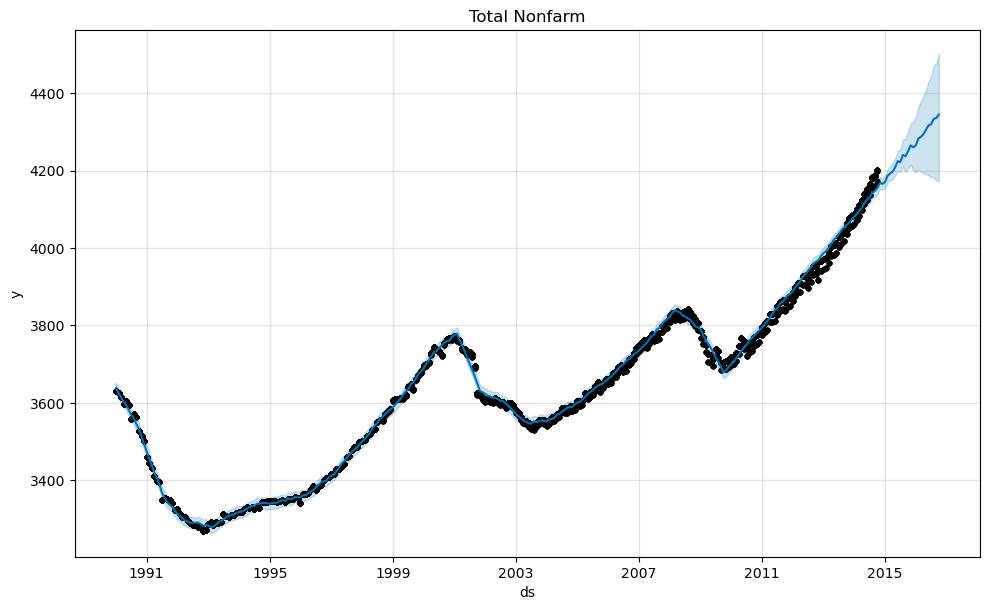

Total Nonfarm RMSE: 42.99722007048297
Processing Total Private


19:59:11 - cmdstanpy - INFO - Chain [1] start processing
19:59:38 - cmdstanpy - INFO - Chain [1] done processing


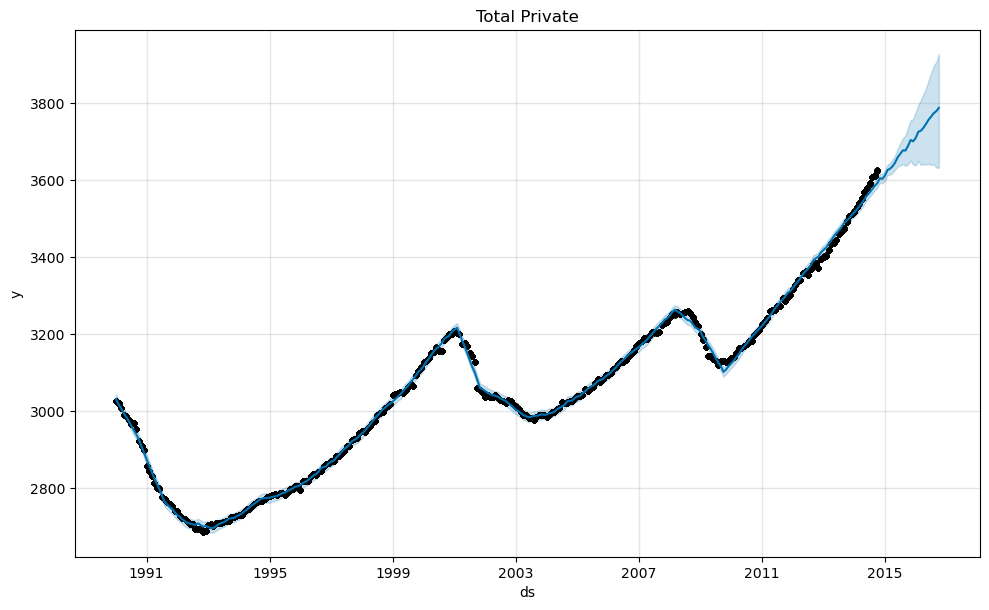

Total Private RMSE: 33.22641251896077
Processing Education and Health Services


19:59:40 - cmdstanpy - INFO - Chain [1] start processing
19:59:59 - cmdstanpy - INFO - Chain [1] done processing


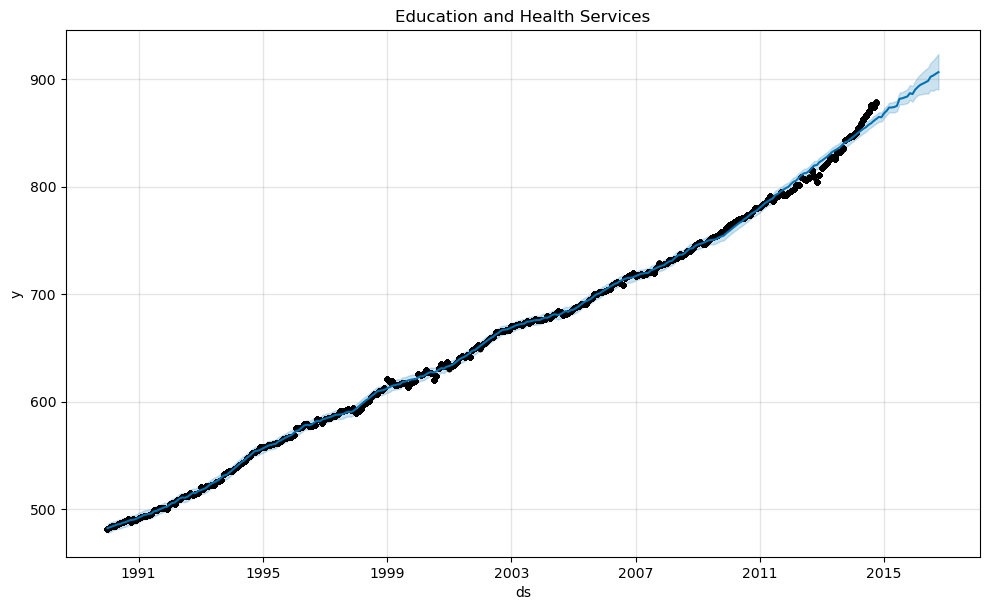

Education and Health Services RMSE: 15.114737283953438
Processing Professional and Business Services


20:00:01 - cmdstanpy - INFO - Chain [1] start processing
20:00:29 - cmdstanpy - INFO - Chain [1] done processing


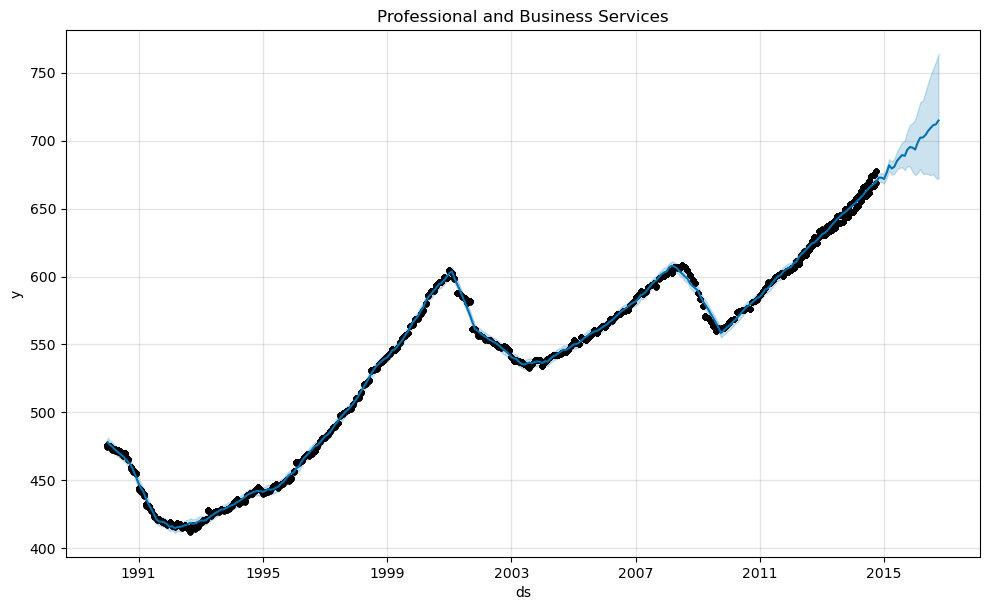

Professional and Business Services RMSE: 5.006488035782211
Processing Public Administration


20:00:32 - cmdstanpy - INFO - Chain [1] start processing
20:00:56 - cmdstanpy - INFO - Chain [1] done processing


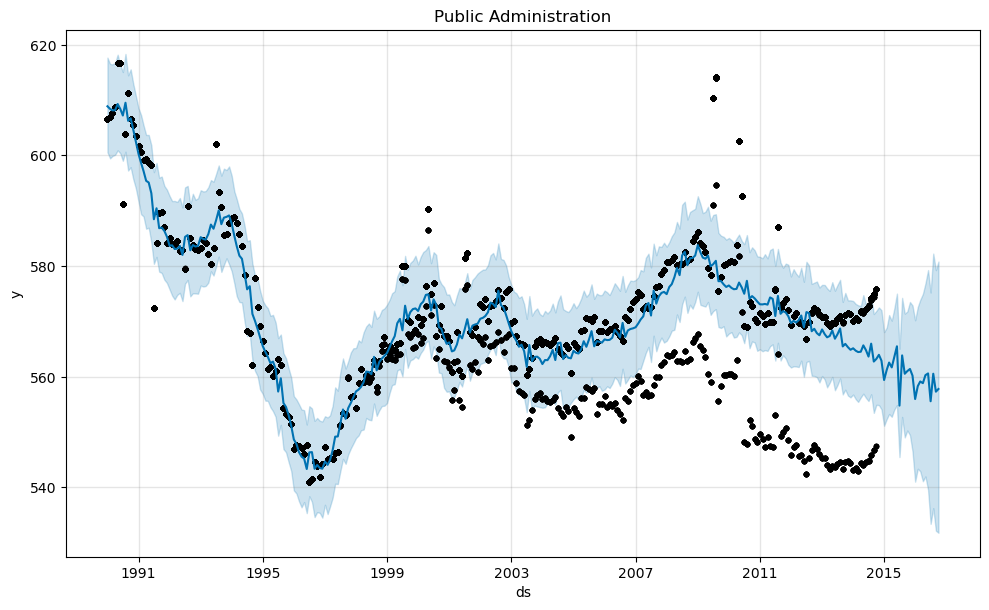

Public Administration RMSE: 13.056833898513677


In [7]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from math import sqrt
from prophet import Prophet
from sklearn.model_selection import train_test_split

selected_industries = ['Total Nonfarm', 'Total Private', 'Education and Health Services', 'Professional and Business Services', 'Public Administration']

# Loop through each selected industry
for industry in selected_industries:
    print(f'Processing {industry}')
    industry_data = df[df['INDUSTRY'] == industry].copy()
    industry_data.sort_values('DATE', inplace=True)
    
    # Prepare the data for the Prophet model
    prophet_data = industry_data[['DATE', 'EMPLOYMENT']]
    prophet_data.columns = ['ds', 'y']  # Prophet requires the date column to be 'ds' and the value column to be 'y'

    # Split the data into training and testing data
    train, test = train_test_split(prophet_data, test_size=0.2, shuffle=False)

    # Create and fit the Prophet model using training data
    model = Prophet(yearly_seasonality=True)
    model.fit(train)
    
    # Make a future dataframe for 2 years
    future = model.make_future_dataframe(periods=24, freq='M')
    
    # Make predictions
    forecast = model.predict(future)
    
    # Plot the forecast
    model.plot(forecast)
    plt.title(industry)
    plt.show()

    # Align the original and forecast dataframes on date
    merged = test.merge(forecast[['ds', 'yhat']], how='inner', left_on='ds', right_on='ds')

    # Calculate the RMSE
    rmse = sqrt(mean_squared_error(merged['y'], merged['yhat']))

    print(f'{industry} RMSE: {rmse}')


In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from prophet import Prophet
from sklearn.model_selection import train_test_split

# Define the selected industries
selected_industries = ['Total Nonfarm', 'Total Private', 'Education and Health Services', 'Professional and Business Services', 'Public Administration']

# Prepare a dictionary to store the RMSE values for each industry
rmse_values = {}

# Loop through each selected industry
for industry in selected_industries:
    print(f'Processing {industry}')
    industry_data = df[df['INDUSTRY'] == industry].copy()
    industry_data.sort_values('DATE', inplace=True)
    
    # Prepare the data for the Prophet model
    prophet_data = industry_data[['DATE', 'EMPLOYMENT']]
    prophet_data.columns = ['ds', 'y']  # Prophet requires the date column to be 'ds' and the value column to be 'y'
    
    # Split the data into training and testing data
    train, test = train_test_split(prophet_data, test_size=0.2, shuffle=False)
    
    # Create and fit the Prophet model using training data
    model = Prophet(yearly_seasonality=True)
    model.fit(train)
    
    # Make a future dataframe for 2 years
    future = model.make_future_dataframe(periods=24, freq='M')
    
    # Make predictions
    forecast = model.predict(future)
    
    # Align the original and forecast dataframes on date
    merged = test.merge(forecast[['ds', 'yhat']], how='inner', left_on='ds', right_on='ds')
    
    # Calculate the RMSE
    rmse = sqrt(mean_squared_error(merged['y'], merged['yhat']))

    # Store the RMSE value
    rmse_values[industry] = rmse

# Print the RMSE values for each industry
for industry, rmse in rmse_values.items():
    print(f'{industry} RMSE: {rmse}')


Processing Total Nonfarm


01:52:46 - cmdstanpy - INFO - Chain [1] start processing
01:53:11 - cmdstanpy - INFO - Chain [1] done processing


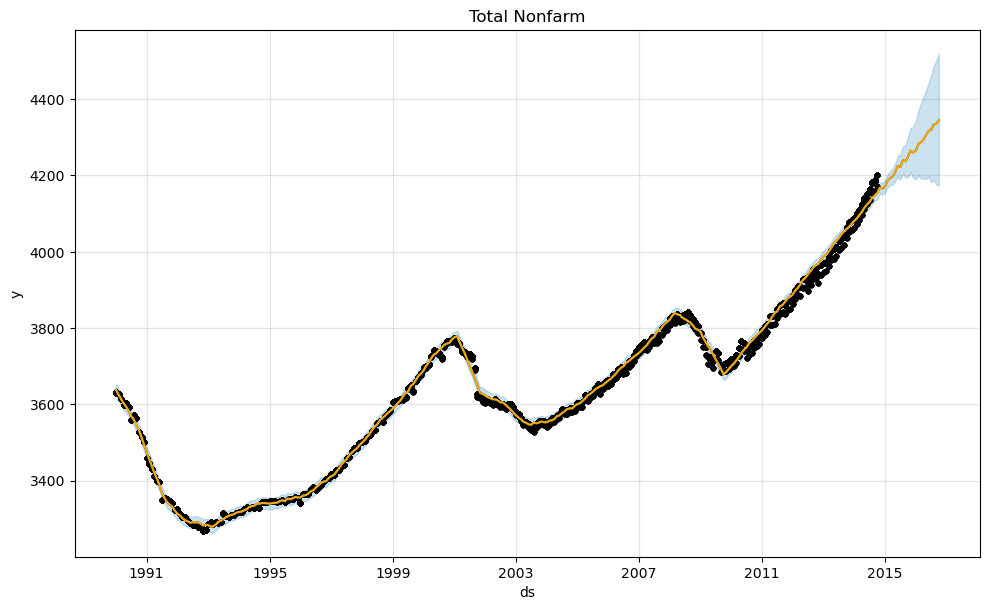

Total Nonfarm RMSE: 42.99722007048297
Processing Total Private


01:53:12 - cmdstanpy - INFO - Chain [1] start processing
01:53:33 - cmdstanpy - INFO - Chain [1] done processing


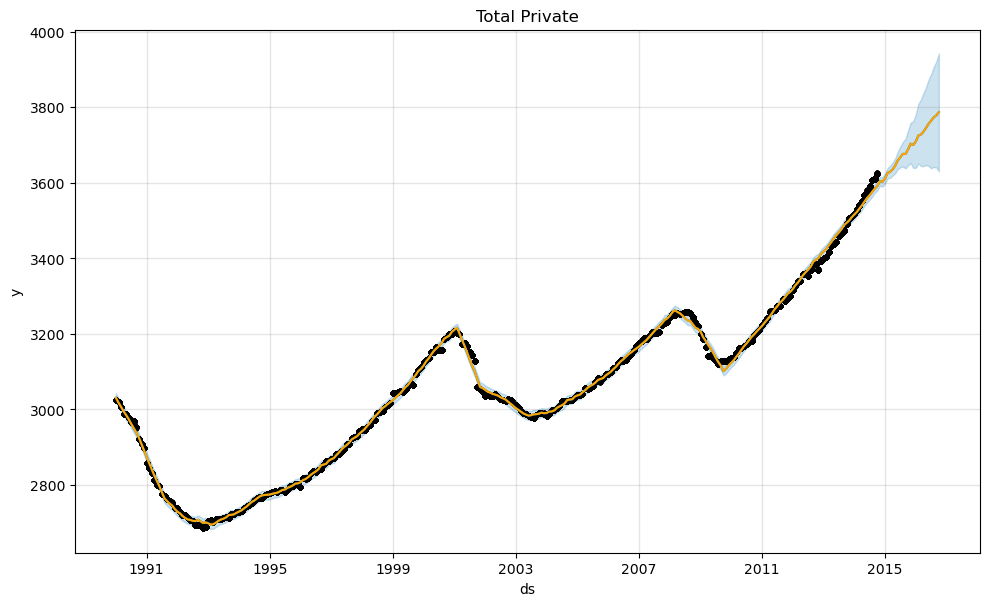

Total Private RMSE: 33.22641251896077
Processing Education and Health Services


01:53:35 - cmdstanpy - INFO - Chain [1] start processing
01:53:53 - cmdstanpy - INFO - Chain [1] done processing


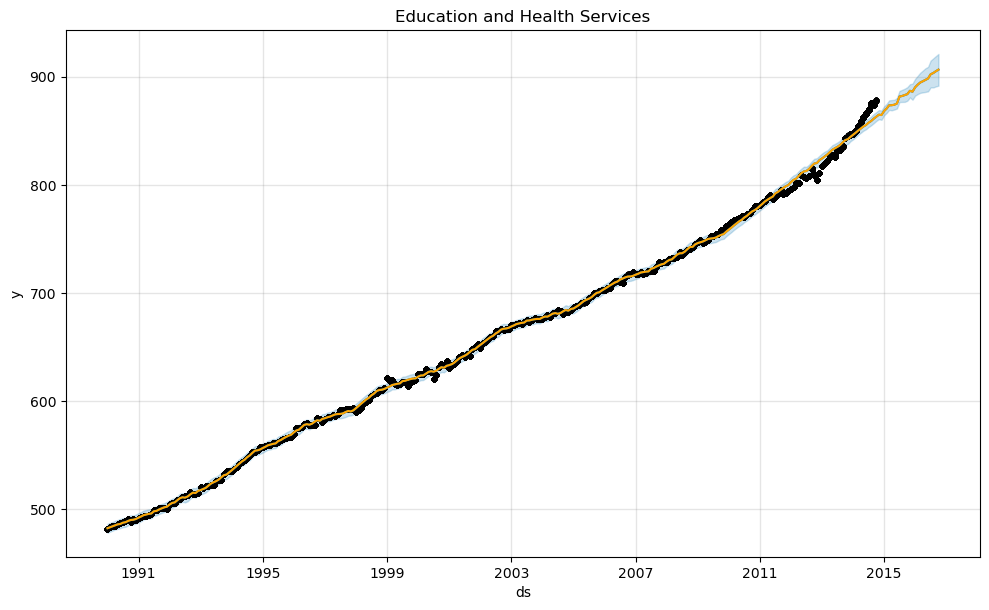

Education and Health Services RMSE: 15.114737283953438
Processing Professional and Business Services


01:53:55 - cmdstanpy - INFO - Chain [1] start processing
01:54:18 - cmdstanpy - INFO - Chain [1] done processing


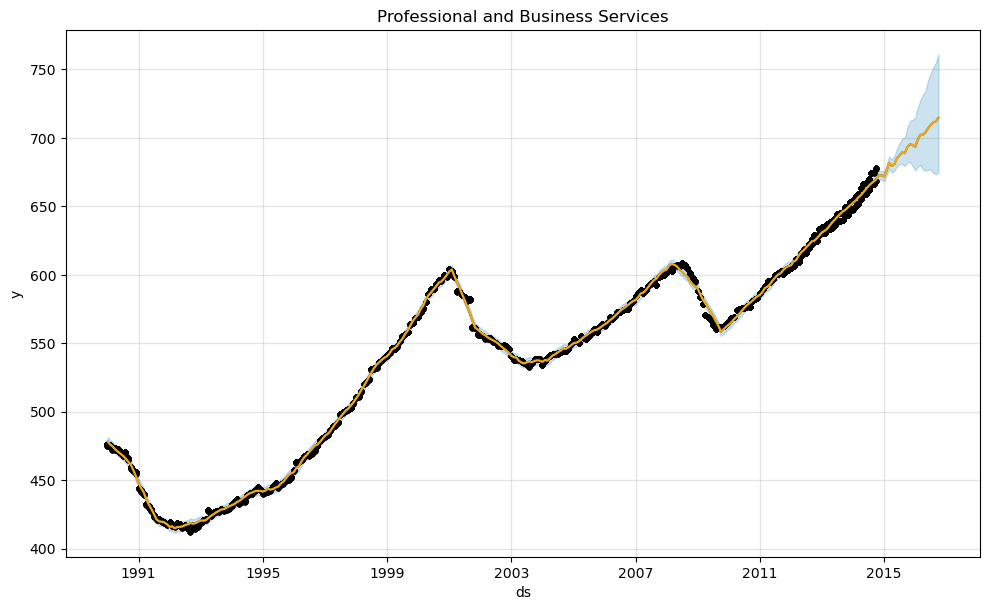

Professional and Business Services RMSE: 5.006488035782211
Processing Public Administration


01:54:20 - cmdstanpy - INFO - Chain [1] start processing
01:54:36 - cmdstanpy - INFO - Chain [1] done processing


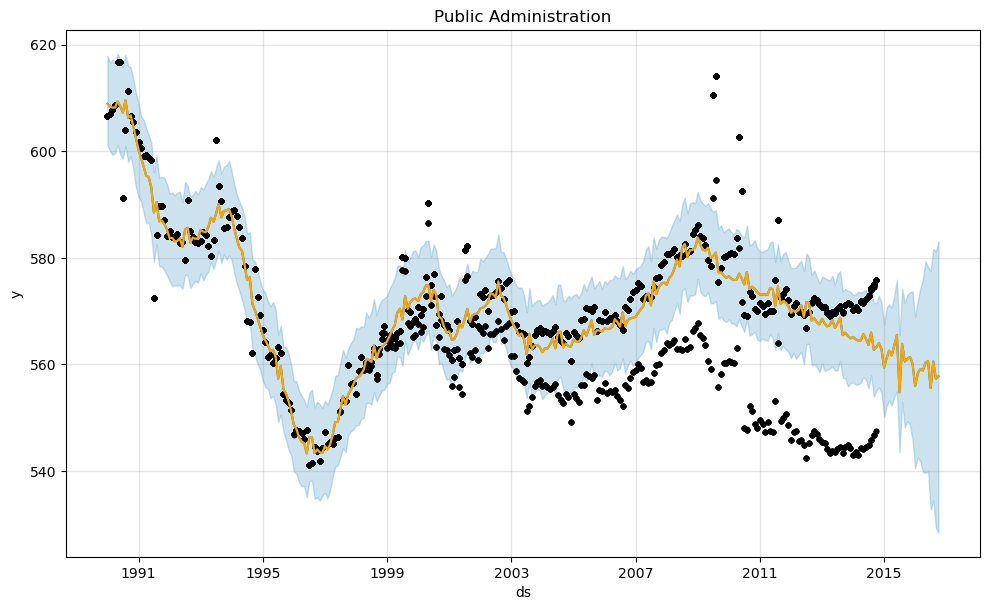

Public Administration RMSE: 13.056833898513677


In [5]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from math import sqrt
from prophet import Prophet
from sklearn.model_selection import train_test_split

selected_industries = ['Total Nonfarm', 'Total Private', 'Education and Health Services', 'Professional and Business Services', 'Public Administration']

# Loop through each selected industry
for industry in selected_industries:
    print(f'Processing {industry}')
    industry_data = df[df['INDUSTRY'] == industry].copy()
    industry_data.sort_values('DATE', inplace=True)
    
    # Prepare the data for the Prophet model
    prophet_data = industry_data[['DATE', 'EMPLOYMENT']]
    prophet_data.columns = ['ds', 'y']  # Prophet requires the date column to be 'ds' and the value column to be 'y'

    # Split the data into training and testing data
    train, test = train_test_split(prophet_data, test_size=0.2, shuffle=False)

    # Create and fit the Prophet model using training data
    model = Prophet(yearly_seasonality=True)
    model.fit(train)
    
    # Make a future dataframe for 2 years
    future = model.make_future_dataframe(periods=24, freq='M')
    
    # Make predictions
    forecast = model.predict(future)
    
    # Plot the forecast
    fig1 = model.plot(forecast)

    # Manually plot the future forecast
    plt.plot(forecast['ds'], forecast['yhat'], color='orange', label='forecast')

    plt.title(industry)
    plt.show()

    # Align the original and forecast dataframes on date
    merged = test.merge(forecast[['ds', 'yhat']], how='inner', left_on='ds', right_on='ds')

    # Calculate the RMSE
    rmse = sqrt(mean_squared_error(merged['y'], merged['yhat']))

    print(f'{industry} RMSE: {rmse}')


In [6]:
print(train['ds'].min(), train['ds'].max())
print(test['ds'].min(), test['ds'].max())


1990-01-01 00:00:00 2014-10-01 00:00:00
2014-10-01 00:00:00 2023-06-01 00:00:00


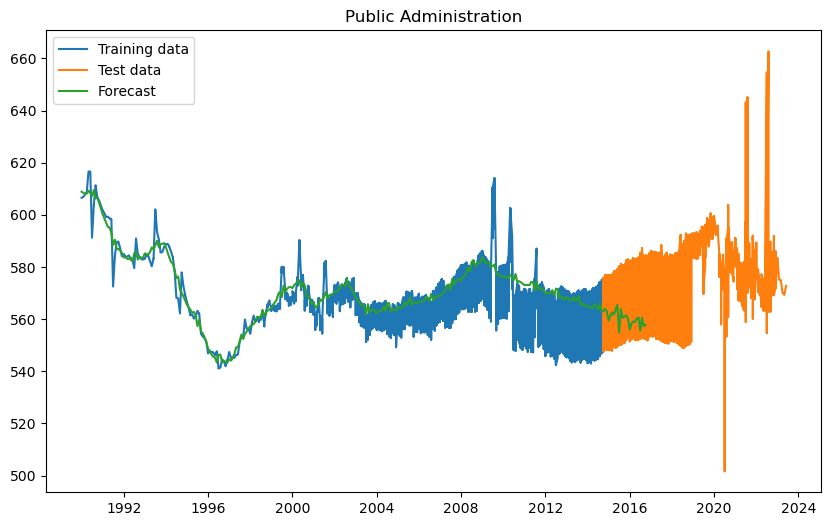

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(train['ds'], train['y'], label='Training data')
plt.plot(test['ds'], test['y'], label='Test data')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast')
plt.legend()
plt.title(industry)
plt.show()


Processing Total Nonfarm


02:03:09 - cmdstanpy - INFO - Chain [1] start processing
02:03:34 - cmdstanpy - INFO - Chain [1] done processing


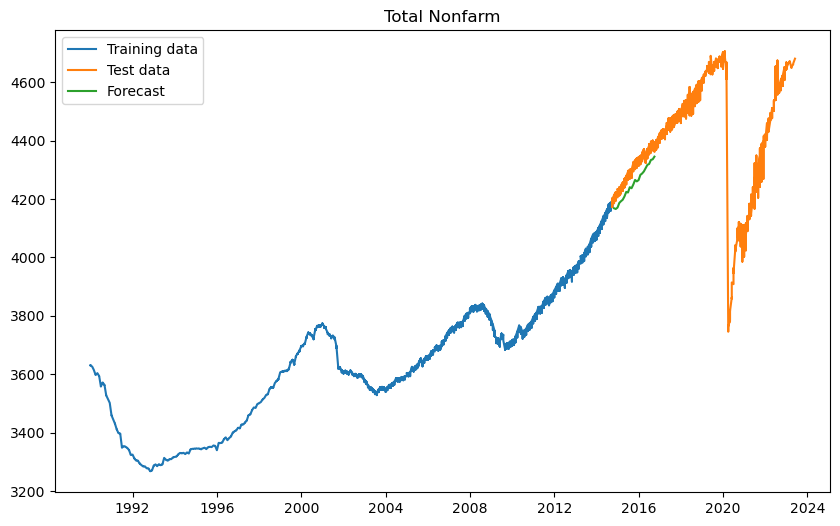

Total Nonfarm RMSE: 42.99722007048297
Processing Total Private


02:03:35 - cmdstanpy - INFO - Chain [1] start processing
02:04:00 - cmdstanpy - INFO - Chain [1] done processing


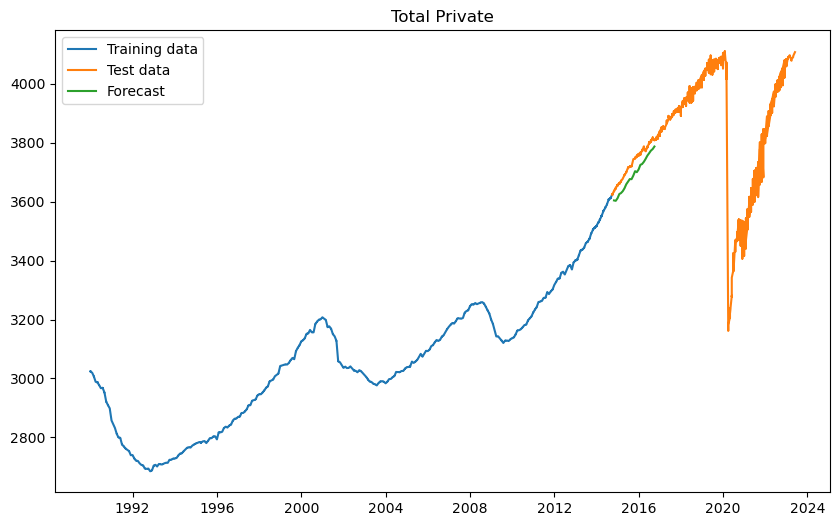

Total Private RMSE: 33.22641251896077
Processing Education and Health Services


02:04:02 - cmdstanpy - INFO - Chain [1] start processing
02:04:21 - cmdstanpy - INFO - Chain [1] done processing


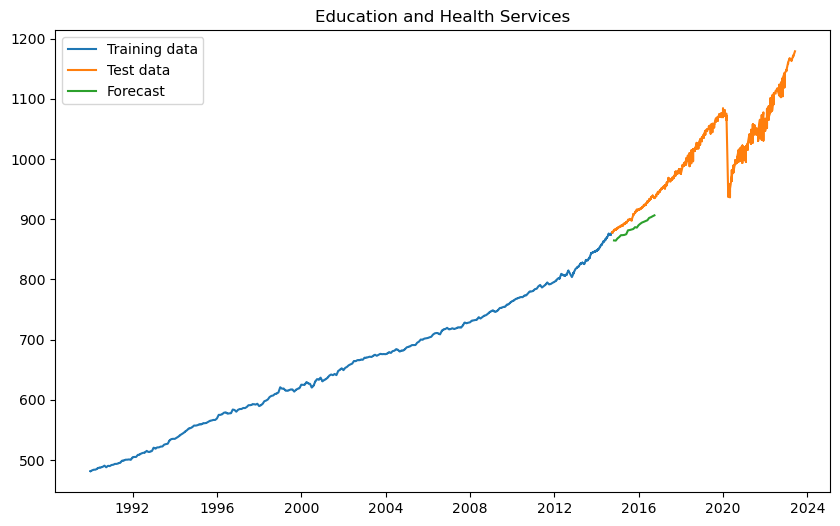

Education and Health Services RMSE: 15.114737283953438
Processing Professional and Business Services


02:04:23 - cmdstanpy - INFO - Chain [1] start processing
02:04:47 - cmdstanpy - INFO - Chain [1] done processing


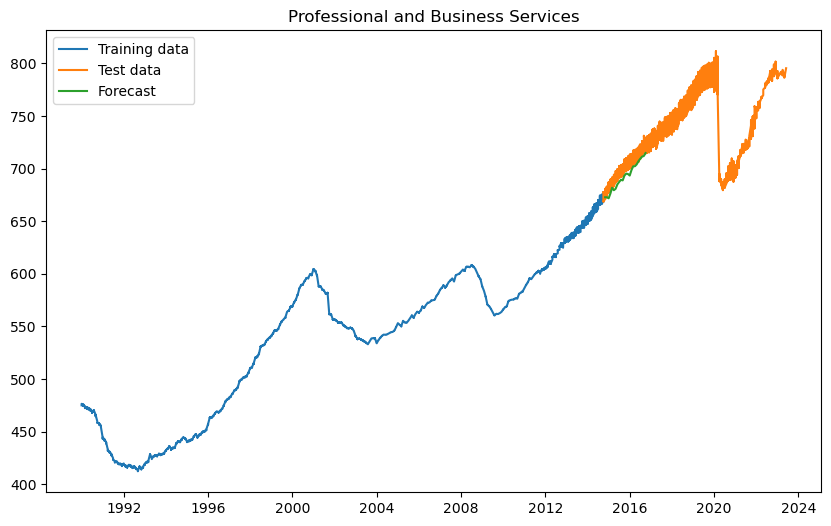

Professional and Business Services RMSE: 5.006488035782211
Processing Public Administration


02:04:49 - cmdstanpy - INFO - Chain [1] start processing
02:05:07 - cmdstanpy - INFO - Chain [1] done processing


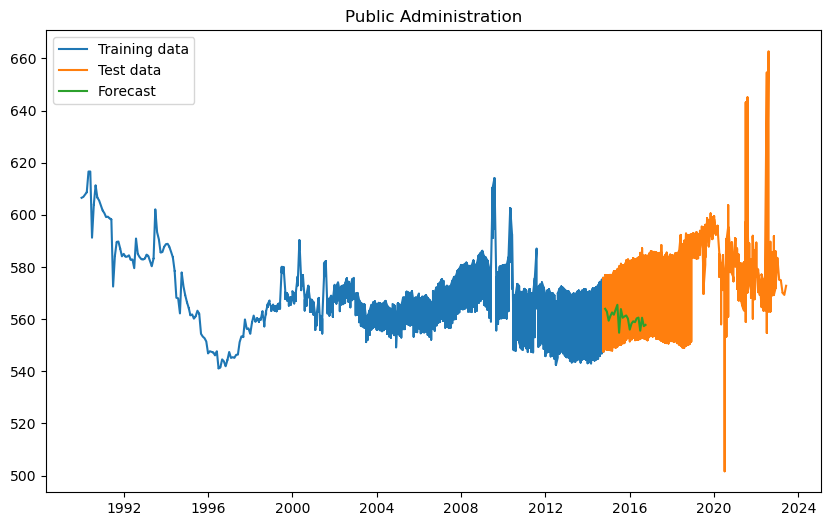

Public Administration RMSE: 13.056833898513677


In [9]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from prophet import Prophet
from sklearn.model_selection import train_test_split

selected_industries = ['Total Nonfarm', 'Total Private', 'Education and Health Services', 'Professional and Business Services', 'Public Administration']

# Loop through each selected industry
for industry in selected_industries:
    print(f'Processing {industry}')
    industry_data = df[df['INDUSTRY'] == industry].copy()
    industry_data.sort_values('DATE', inplace=True)
    
    # Prepare the data for the Prophet model
    prophet_data = industry_data[['DATE', 'EMPLOYMENT']]
    prophet_data.columns = ['ds', 'y']  # Prophet requires the date column to be 'ds' and the value column to be 'y'

    # Split the data into training and testing data
    train, test = train_test_split(prophet_data, test_size=0.2, shuffle=False)

    # Create and fit the Prophet model using training data
    model = Prophet(yearly_seasonality=True)
    model.fit(train)
    
    # Make a future dataframe for 2 years
    future = model.make_future_dataframe(periods=24, freq='M')
    
    # Make predictions
    forecast = model.predict(future)
    
    # Plot the forecast
    plt.figure(figsize=(10, 6))
    plt.plot(train['ds'], train['y'], label='Training data')
    plt.plot(test['ds'], test['y'], label='Test data')

    # Only plot the forecast for dates greater than the max date in the training data
    forecast_future = forecast[forecast['ds'] > test['ds'].min()]
    plt.plot(forecast_future['ds'], forecast_future['yhat'], label='Forecast')
    plt.legend()
    plt.title(industry)
    plt.show()

    # Align the original and forecast dataframes on date
    merged = test.merge(forecast[['ds', 'yhat']], how='inner', left_on='ds', right_on='ds')

    # Calculate the RMSE
    rmse = sqrt(mean_squared_error(merged['y'], merged['yhat']))

    print(f'{industry} RMSE: {rmse}')


Processing Total Nonfarm


02:08:02 - cmdstanpy - INFO - Chain [1] start processing
02:08:27 - cmdstanpy - INFO - Chain [1] done processing


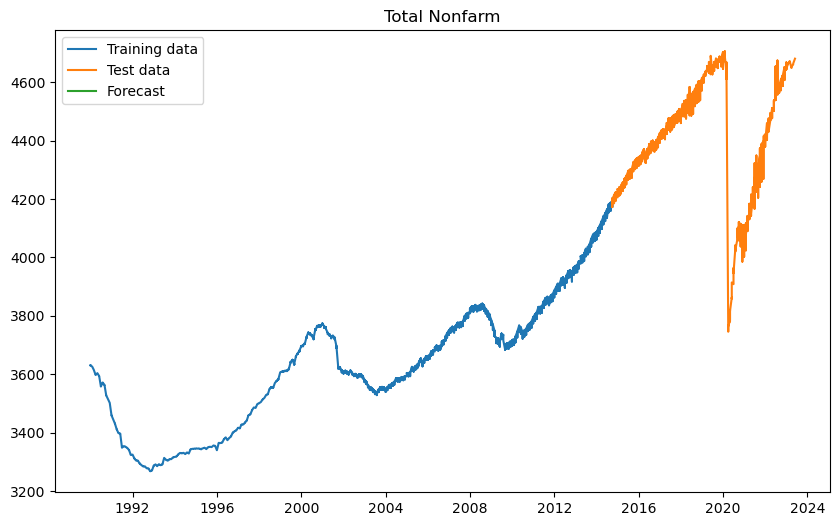

Total Nonfarm RMSE: 42.99722007048297
Processing Total Private


02:08:29 - cmdstanpy - INFO - Chain [1] start processing
02:08:52 - cmdstanpy - INFO - Chain [1] done processing


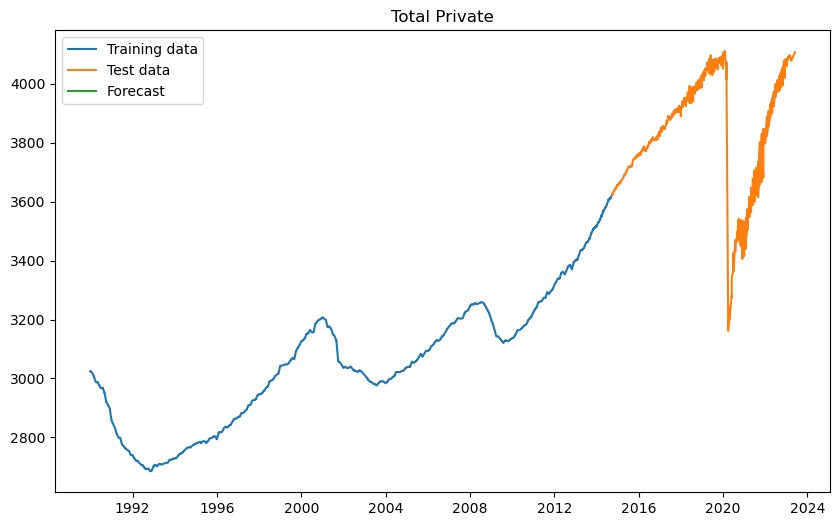

Total Private RMSE: 33.22641251896077
Processing Education and Health Services


02:08:55 - cmdstanpy - INFO - Chain [1] start processing
02:09:12 - cmdstanpy - INFO - Chain [1] done processing


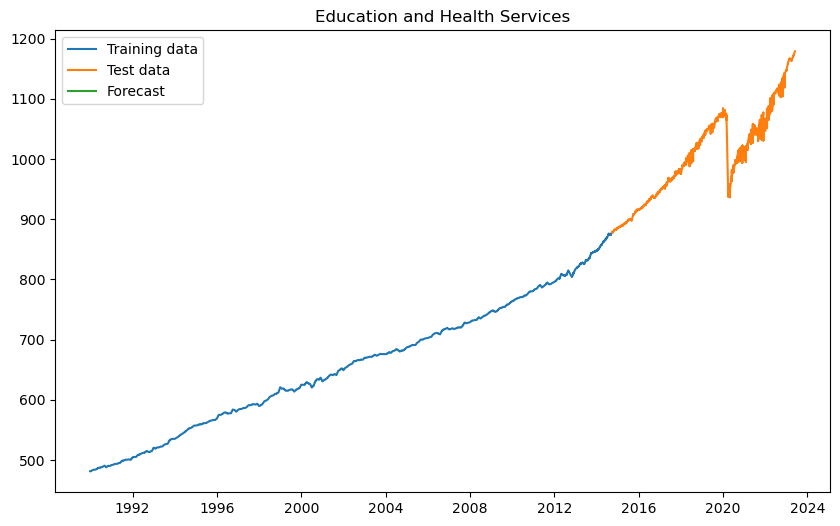

Education and Health Services RMSE: 15.114737283953438
Processing Professional and Business Services


02:09:13 - cmdstanpy - INFO - Chain [1] start processing
02:09:35 - cmdstanpy - INFO - Chain [1] done processing


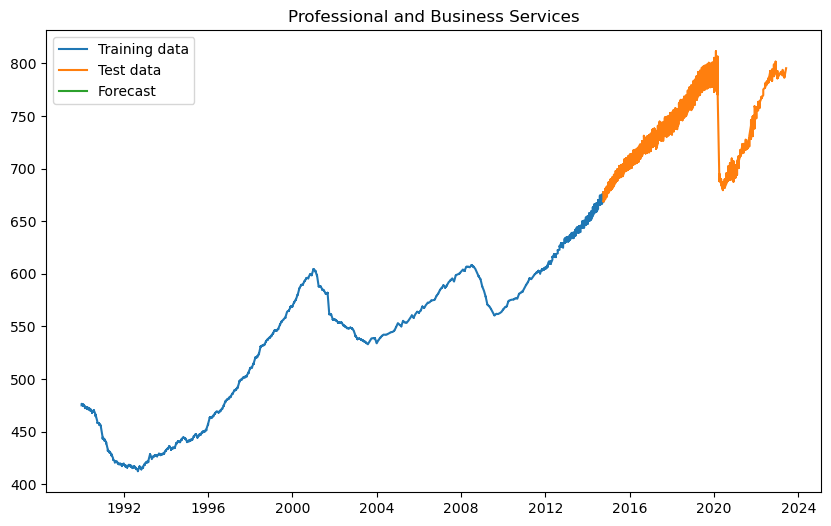

Professional and Business Services RMSE: 5.006488035782211
Processing Public Administration


02:09:37 - cmdstanpy - INFO - Chain [1] start processing
02:09:54 - cmdstanpy - INFO - Chain [1] done processing


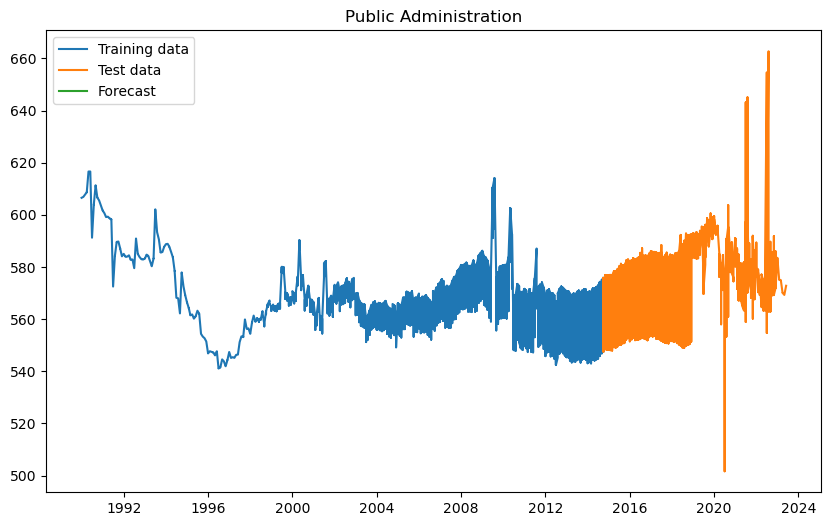

Public Administration RMSE: 13.056833898513677


In [10]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from prophet import Prophet
from sklearn.model_selection import train_test_split

selected_industries = ['Total Nonfarm', 'Total Private', 'Education and Health Services', 'Professional and Business Services', 'Public Administration']

# Loop through each selected industry
for industry in selected_industries:
    print(f'Processing {industry}')
    industry_data = df[df['INDUSTRY'] == industry].copy()
    industry_data.sort_values('DATE', inplace=True)
    
    # Prepare the data for the Prophet model
    prophet_data = industry_data[['DATE', 'EMPLOYMENT']]
    prophet_data.columns = ['ds', 'y']  # Prophet requires the date column to be 'ds' and the value column to be 'y'

    # Split the data into training and testing data
    train, test = train_test_split(prophet_data, test_size=0.2, shuffle=False)

    # Create and fit the Prophet model using training data
    model = Prophet(yearly_seasonality=True)
    model.fit(train)
    
    # Make a future dataframe for 2 years
    future = model.make_future_dataframe(periods=24, freq='M')
    
    # Make predictions
    forecast = model.predict(future)
    
    # Plot the forecast
    plt.figure(figsize=(10, 6))
    plt.plot(train['ds'], train['y'], label='Training data')
    plt.plot(test['ds'], test['y'], label='Test data')

    # Only plot the forecast for dates greater than the max date in the test data
    forecast_future = forecast[forecast['ds'] > test['ds'].max()]
    plt.plot(forecast_future['ds'], forecast_future['yhat'], label='Forecast')
    plt.legend()
    plt.title(industry)
    plt.show()

    # Align the original and forecast dataframes on date
    merged = test.merge(forecast[['ds', 'yhat']], how='inner', left_on='ds', right_on='ds')

    # Calculate the RMSE
    rmse = sqrt(mean_squared_error(merged['y'], merged['yhat']))

    print(f'{industry} RMSE: {rmse}')


Processing Total Nonfarm


02:33:03 - cmdstanpy - INFO - Chain [1] start processing
02:33:28 - cmdstanpy - INFO - Chain [1] done processing


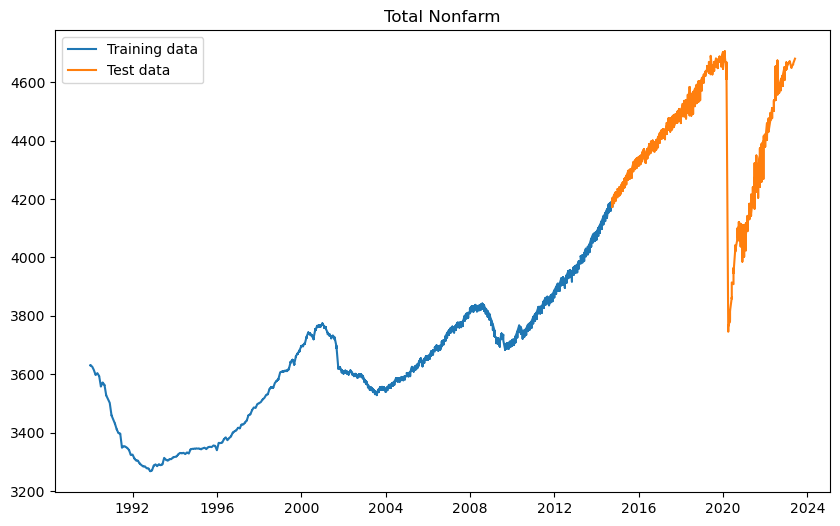

Total Nonfarm RMSE: 42.99722007048297
Processing Total Private


02:33:29 - cmdstanpy - INFO - Chain [1] start processing
02:33:52 - cmdstanpy - INFO - Chain [1] done processing


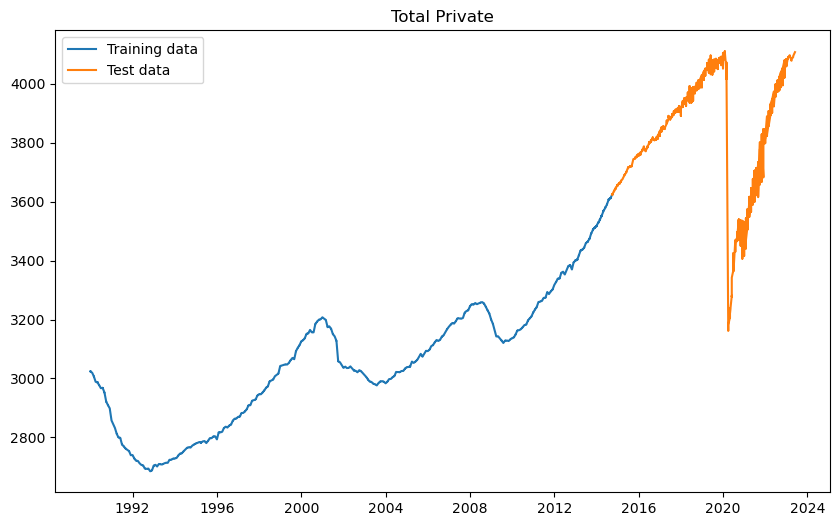

Total Private RMSE: 33.22641251896077
Processing Education and Health Services


02:33:53 - cmdstanpy - INFO - Chain [1] start processing
02:34:12 - cmdstanpy - INFO - Chain [1] done processing


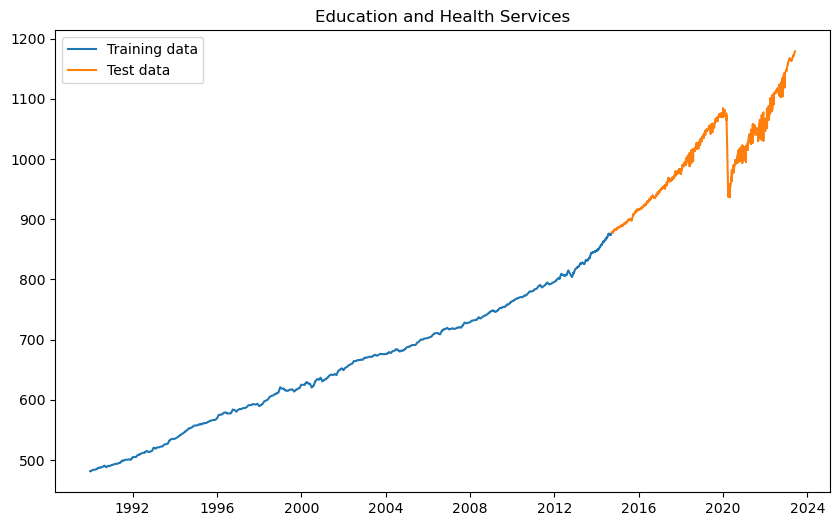

Education and Health Services RMSE: 15.114737283953438
Processing Professional and Business Services


02:34:14 - cmdstanpy - INFO - Chain [1] start processing
02:34:35 - cmdstanpy - INFO - Chain [1] done processing


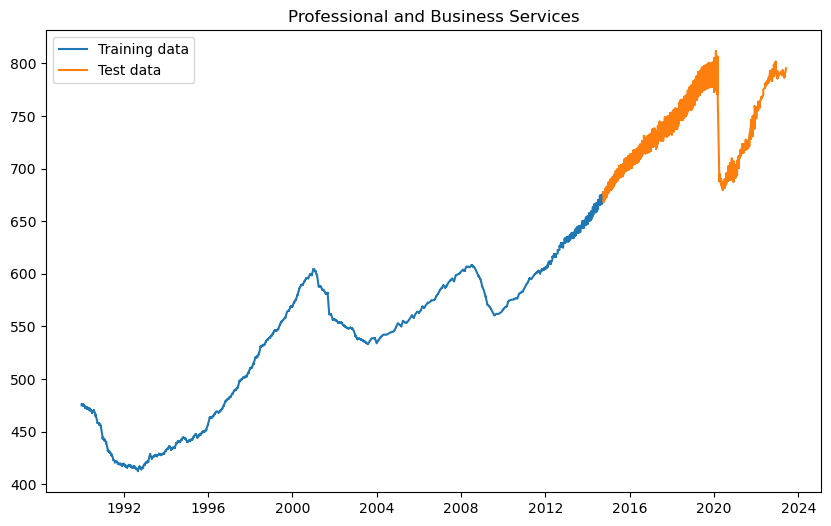

Professional and Business Services RMSE: 5.006488035782211
Processing Public Administration


02:34:37 - cmdstanpy - INFO - Chain [1] start processing
02:34:55 - cmdstanpy - INFO - Chain [1] done processing


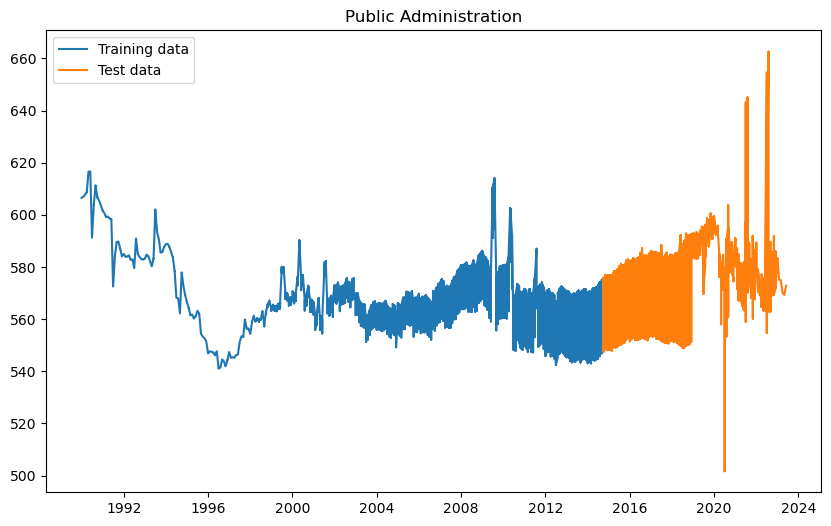

Public Administration RMSE: 13.056833898513677


In [16]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from prophet import Prophet
from sklearn.model_selection import train_test_split

selected_industries = ['Total Nonfarm', 'Total Private', 'Education and Health Services', 'Professional and Business Services', 'Public Administration']

# Loop through each selected industry
for industry in selected_industries:
    print(f'Processing {industry}')
    industry_data = df[df['INDUSTRY'] == industry].copy()
    industry_data.sort_values('DATE', inplace=True)
    
    # Prepare the data for the Prophet model
    prophet_data = industry_data[['DATE', 'EMPLOYMENT']]
    prophet_data.columns = ['ds', 'y']  # Prophet requires the date column to be 'ds' and the value column to be 'y'

    # Split the data into training and testing data
    train, test = train_test_split(prophet_data, test_size=0.2, shuffle=False)

    # Create and fit the Prophet model using training data
    model = Prophet(yearly_seasonality=True)
    model.fit(train)
    
    # Make a future dataframe for 2 years
    future = model.make_future_dataframe(periods=24, freq='M')
    
    # Make predictions
    forecast = model.predict(future)
    
    # Plot the training and testing data
    plt.figure(figsize=(10, 6))
    plt.plot(train['ds'], train['y'], label='Training data')
    plt.plot(test['ds'], test['y'], label='Test data')
    plt.legend()
    plt.title(industry)
    plt.show()

    # Align the original and forecast dataframes on date
    merged = test.merge(forecast[['ds', 'yhat']], how='inner', left_on='ds', right_on='ds')

    # Calculate the RMSE
    rmse = sqrt(mean_squared_error(merged['y'], merged['yhat']))

    print(f'{industry} RMSE: {rmse}')


Processing Total Nonfarm


19:34:36 - cmdstanpy - INFO - Chain [1] start processing
19:35:03 - cmdstanpy - INFO - Chain [1] done processing


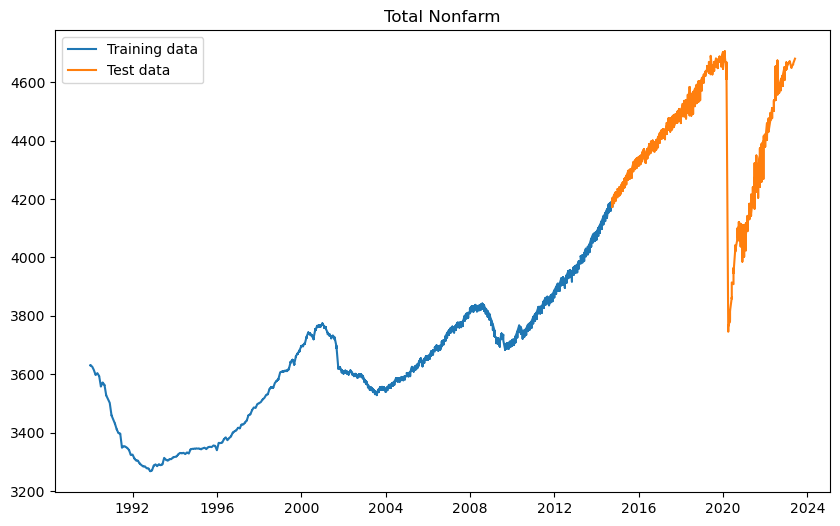

Total Nonfarm RMSE: 42.99722007048297
Processing Total Private


19:35:05 - cmdstanpy - INFO - Chain [1] start processing
19:35:28 - cmdstanpy - INFO - Chain [1] done processing


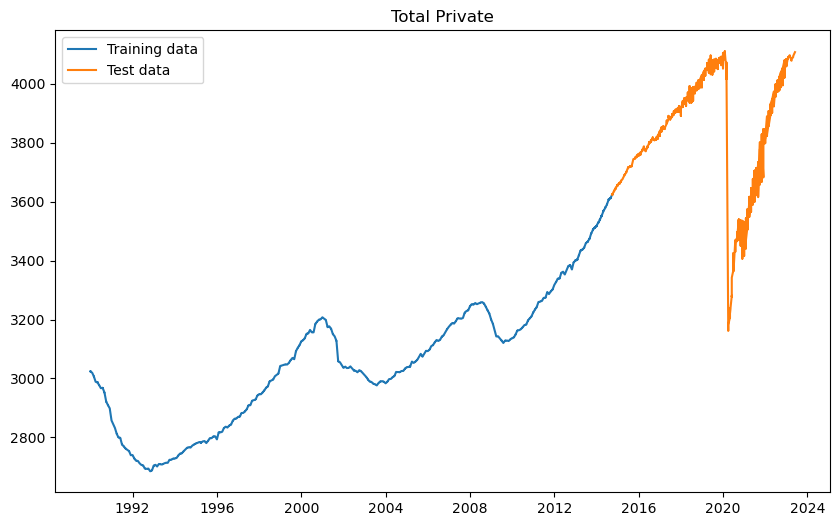

Total Private RMSE: 33.22641251896077
Processing Education and Health Services


19:35:30 - cmdstanpy - INFO - Chain [1] start processing
19:35:49 - cmdstanpy - INFO - Chain [1] done processing


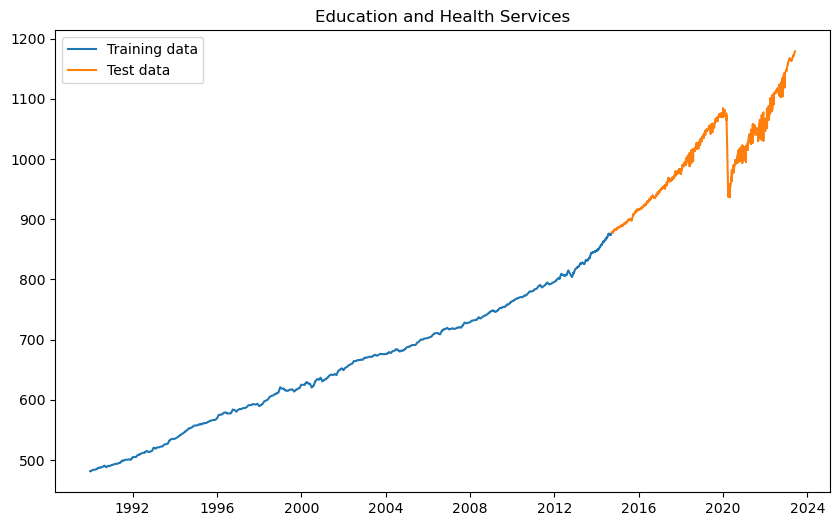

Education and Health Services RMSE: 15.114737283953438
Processing Professional and Business Services


19:35:51 - cmdstanpy - INFO - Chain [1] start processing
19:36:17 - cmdstanpy - INFO - Chain [1] done processing


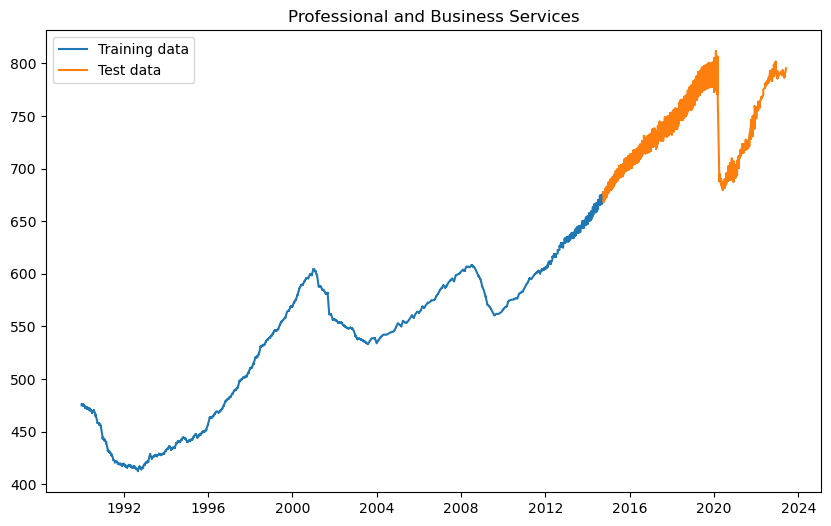

Professional and Business Services RMSE: 5.006488035782211
Processing Public Administration


19:36:19 - cmdstanpy - INFO - Chain [1] start processing
19:36:39 - cmdstanpy - INFO - Chain [1] done processing


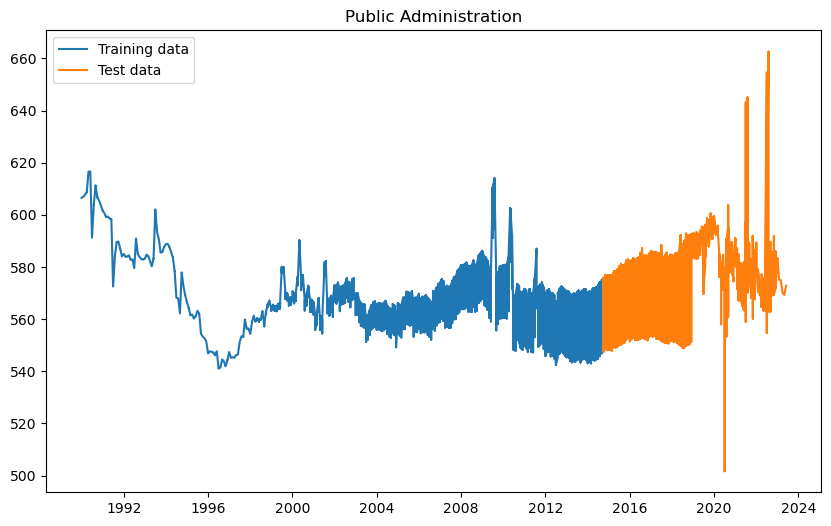

Public Administration RMSE: 13.056833898513677


In [6]:

from sklearn.metrics import mean_squared_error
from math import sqrt
from prophet import Prophet
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

selected_industries = ['Total Nonfarm', 'Total Private', 'Education and Health Services', 'Professional and Business Services', 'Public Administration']

# Loop through each selected industry
for industry in selected_industries:
    print(f'Processing {industry}')
    industry_data = df[df['INDUSTRY'] == industry].copy()
    industry_data.sort_values('DATE', inplace=True)
    
    # Prepare the data for the Prophet model
    prophet_data = industry_data[['DATE', 'EMPLOYMENT']]
    prophet_data.columns = ['ds', 'y']  # Prophet requires the date column to be 'ds' and the value column to be 'y'

    # Split the data into training and testing data
    train, test = train_test_split(prophet_data, test_size=0.2, shuffle=False)

    # Create and fit the Prophet model using training data
    model = Prophet(yearly_seasonality=True)
    model.fit(train)
    
    # Make a future dataframe for 2 years
    future = model.make_future_dataframe(periods=24, freq='M')
    
    # Make predictions
    forecast = model.predict(future)
    
    # Plot the training and testing data
    plt.figure(figsize=(10, 6))
    plt.plot(train['ds'], train['y'], label='Training data')
    plt.plot(test['ds'], test['y'], label='Test data')
    plt.legend()
    plt.title(industry)
    plt.show(block=True)  # 显示全屏图表

    # Align the original and forecast dataframes on date
    merged = test.merge(forecast[['ds', 'yhat']], how='inner', left_on='ds', right_on='ds')

    # Calculate the RMSE
    rmse = sqrt(mean_squared_error(merged['y'], merged['yhat']))

    print(f'{industry} RMSE: {rmse}')

